# VAR
Used for multivariate time series forcasting.

## Exploring the dataset

* We are using the GDP dataset for the USA.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
import statsmodels.api as sm

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [3]:
macro_econ_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(14)
memory usage: 22.3 KB


* In this case we are going to compare the relationship between the 'Real Disposable income' and 'Real Consumption'.

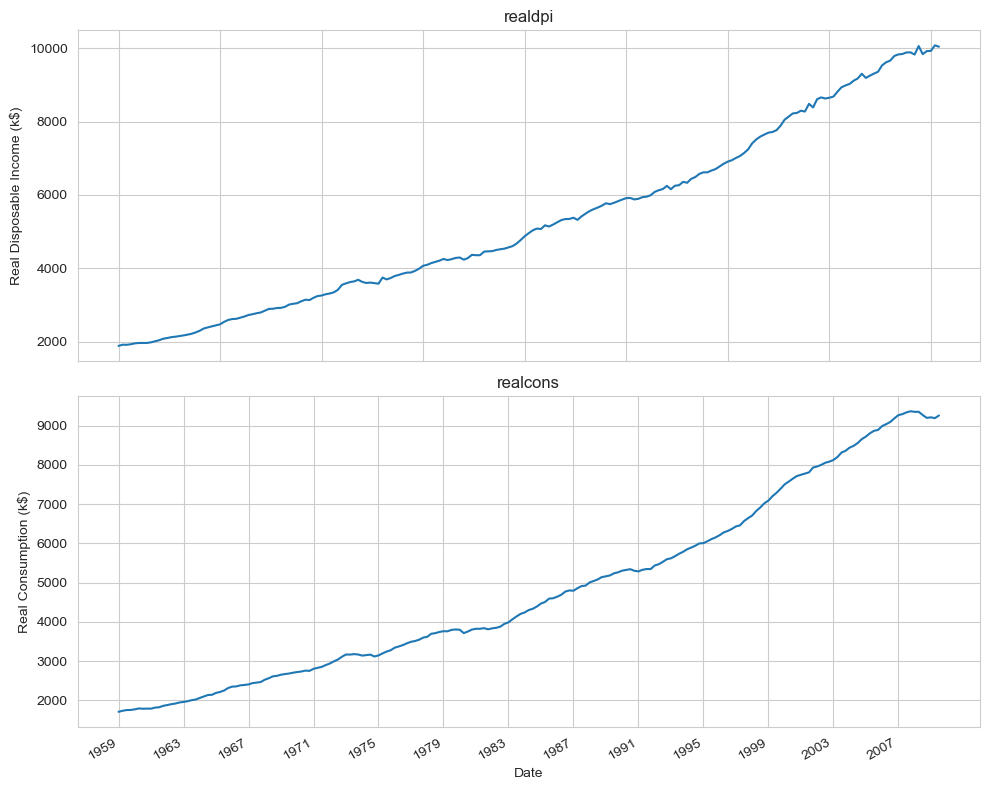

In [4]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10, 8))

axs[0].plot(macro_econ_data['realdpi'])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Real Disposable Income (k$)')
axs[0].set_title('realdpi')

axs[1].plot(macro_econ_data['realcons'])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Real Consumption (k$)')
axs[1].set_title('realcons')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
fig.autofmt_xdate()
plt.tight_layout()

## Testing for Stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller
ADF_realdpi = adfuller(macro_econ_data['realdpi'])
print("ADF Statistic = {}".format(ADF_realdpi[0]))
print("p-value = {}".format(ADF_realdpi[1]))

ADF Statistic = 2.9860253519546878
p-value = 1.0


In [6]:
ADF_realcons = adfuller(macro_econ_data['realcons'])
print("ADF Statistic = {}".format(ADF_realcons[0]))
print("p-value = {}".format(ADF_realcons[1]))

ADF Statistic = 1.549912338050959
p-value = 0.9976992503412904


* As we can see, both the variables do not pass the test.
* We must now convert them to Stationary by differencing.

In [7]:
ADF_realdpi_diff = adfuller(macro_econ_data['realdpi'].diff()[1:])
print("ADF Statistic = {}".format(ADF_realdpi_diff[0]))
print("p-value = {}".format(ADF_realdpi_diff[1]))

ADF Statistic = -8.86489334067301
p-value = 1.4493606159107938e-14


In [8]:
ADF_realcons_diff = adfuller(macro_econ_data['realcons'].diff()[1:])
print("ADF Statistic = {}".format(ADF_realcons_diff[0]))
print("p-value = {}".format(ADF_realcons_diff[1]))

ADF Statistic = -4.204306080845246
p-value = 0.0006479282158627595


* After first order differencing, both the variables pass the test.

## Selecting the best model

In [18]:
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook

def optimize_VAR(endog) -> pd.DataFrame:
    results = []
    for i in tqdm_notebook(range(5)):
        model = VARMAX(endog, order=(i+1, 0)).fit(disp=False)
        aic = model.aic
        results.append([i+1, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [14]:
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]
endog_diff

,realdpi,realcons
1,32.8,26.3
2,-3.3,18.1
3,14.9,1.9
4,24.2,16.8
5,10.6,22.4
...,...,...
198,-220.7,-83.3
199,82.1,-72.4
200,6.0,13.9
201,151.1,-20.2


In [15]:
train = endog_diff[:162]
test = endog_diff[162:]

In [19]:
result_df = optimize_VAR(train)
result_df

C:\Users\delli\AppData\Local\Temp\ipykernel_16432\2737364815.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(5)):


  0%|          | 0/5 [00:00<?, ?it/s]

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,p,AIC
0,3,3123.070078
1,5,3123.708523
2,4,3129.194040
3,2,3130.091668
4,1,3134.333343


* Running all the models we can see that p=3 produces the best model.

## Granger Causality test

* This test is used the test if one of the endogenous seleceted is dependent (causal) of each other.
* If the test returns a p-value is < 0.05 then, one variable is causal of the other.

In [20]:
from statsmodels.tsa.stattools import grangercausalitytests

In [22]:
print("'realcons' Granger-causes 'realdpi'")
print("-----------------------------------")
granger1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], 3)

'realcons' Granger-causes 'realdpi'
-----------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=35.3881 , p=0.0000  , df=1
likelihood ratio test: chi2=32.5962 , p=0.0000  , df=1
parameter F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.6406 , p=0.0000  , df_denom=195, df_num=2
ssr based chi2 test:   chi2=25.9294 , p=0.0000  , df=2
likelihood ratio test: chi2=24.3811 , p=0.0000  , df=2
parameter F test:         F=12.6406 , p=0.0000  , df_denom=195, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3


In [23]:
print("'realdpi' Granger-causes 'realcons'")
print("-----------------------------------")
granger1 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], 3)

'realdpi' Granger-causes 'realcons'
-----------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=7.8540  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7045  , p=0.0055  , df=1
parameter F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9950  , p=0.0523  , df_denom=195, df_num=2
ssr based chi2 test:   chi2=6.1435  , p=0.0463  , df=2
likelihood ratio test: chi2=6.0511  , p=0.0485  , df=2
parameter F test:         F=2.9950  , p=0.0523  , df_denom=195, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


* As we can see both the tests are passed for the p=3.
* So we can see that both the variables are causal of each other.

## Model

In [24]:
best_model = VARMAX(train, order=(3, 0))
best_model_fit = best_model.fit(disp=False)

## Residual Analysis

* As we have 2 variables we have do residual analysis for each of the variables.
* We first take the variable 'realdpi'.

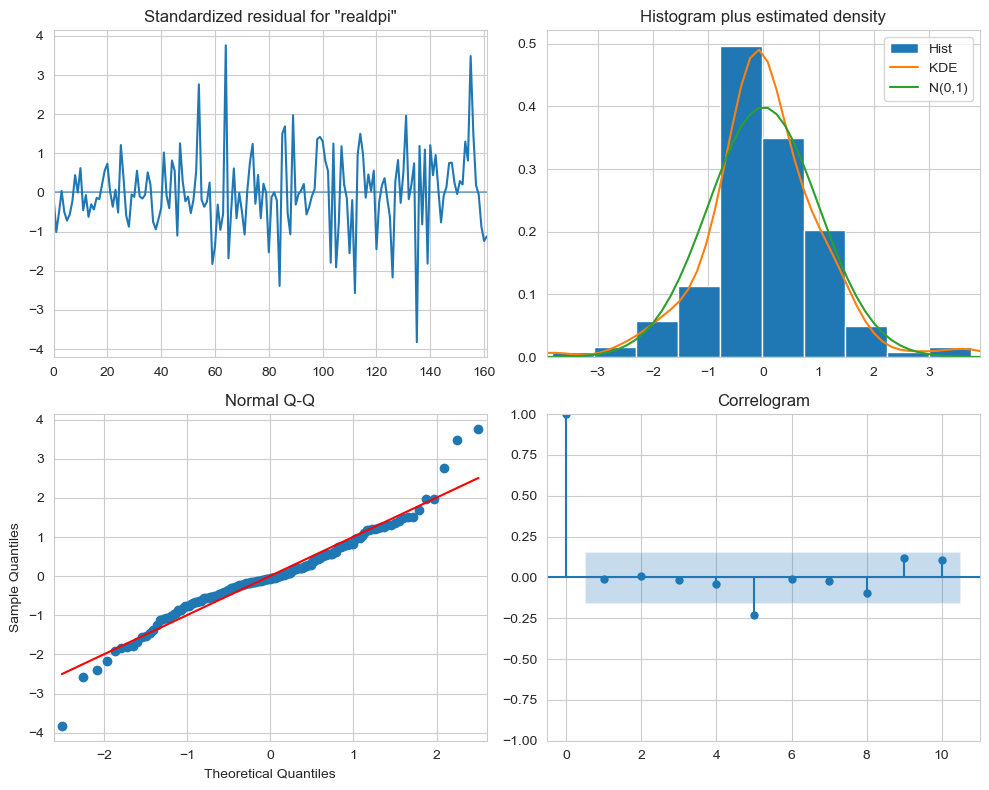

In [25]:
best_model_fit.plot_diagnostics(figsize=(10, 8), variable=0)
plt.tight_layout()

* 'realdpi' passes all the required constraints.
* Now testing for 'realcons'.

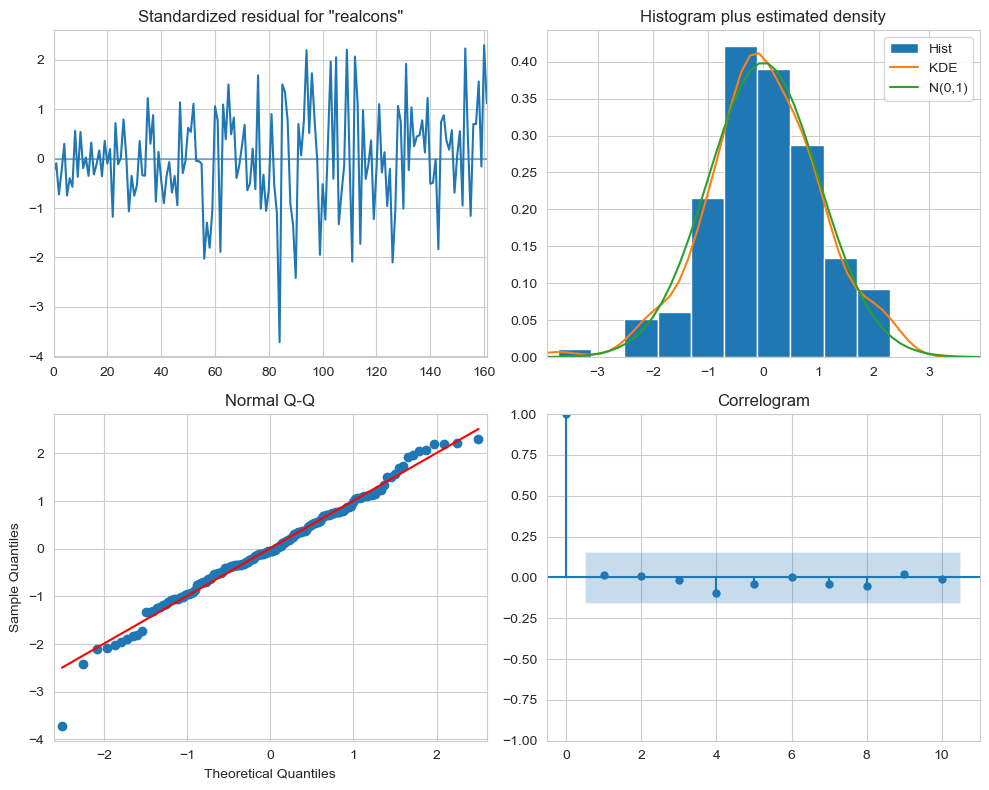

In [26]:
best_model_fit.plot_diagnostics(figsize=(10, 8), variable=1)
plt.tight_layout()

* 'realcons' also passes all the tests.
* Now we have to perform Ljung-Box test for uncorrelation.

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox 

In [28]:
realdpi_residuals = best_model_fit.resid['realdpi']
ljung = acorr_ljungbox(realdpi_residuals, np.arange(1, 11, 1)) # the arrange specifies the lags upto which we are testing, here we are testing the first 10 lags
ljung['lb_pvalue']

1     0.914192
2     0.985437
3     0.994579
4     0.984246
5     0.103506
6     0.164480
7     0.233828
8     0.212591
9     0.148722
10    0.121920
Name: lb_pvalue, dtype: float64

In [29]:
realcons_residuals = best_model_fit.resid['realcons']
ljung = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1)) # the arrange specifies the lags upto which we are testing, here we are testing the first 10 lags
ljung['lb_pvalue']

1     0.877031
2     0.966288
3     0.995312
4     0.993582
5     0.995921
6     0.992408
7     0.994577
8     0.976041
9     0.982522
10    0.991681
Name: lb_pvalue, dtype: float64

* Both the variables pass the uncorrelation test as all the values are > 0.05.

## Forcasting using a rolling function

In [33]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VAR':

        realdpi_pred_VAR = []
        realcons_pred_VAR = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VAR.extend(oos_pred_realdpi)
            realcons_pred_VAR.extend(oos_pred_realcons)
        
        return realdpi_pred_VAR, realcons_pred_VAR
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [34]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR') 

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


* Now we have used differenced forcasts, and we must return it back to its original state.

In [35]:
test = endog[163:]

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

test

C:\Users\delli\AppData\Local\Temp\ipykernel_16432\963654590.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test['realdpi_pred_VAR'] = pd.Series()
C:\Users\delli\AppData\Local\Temp\ipykernel_16432\963654590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['realdpi_pred_VAR'] = pd.Series()
C:\Users\delli\AppData\Local\Temp\ipykernel_16432\963654590.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.224652,7354.326825
164,8053.4,7501.3,7897.189297,7430.259111
165,8135.9,7571.8,7960.563725,7496.634315
166,8222.3,7645.9,8014.758089,7556.621876
167,8234.6,7713.5,8080.704971,7631.007187
168,8296.5,7744.3,8142.395176,7692.856362
169,8273.7,7773.5,8200.126512,7753.877264
170,8484.5,7807.7,8259.366329,7812.546927
171,8385.5,7930.0,8264.390305,7864.647503
172,8611.6,7957.3,8320.862614,7895.072225


In [37]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

C:\Users\delli\AppData\Local\Temp\ipykernel_16432\29680530.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['realdpi_pred_last'] = realdpi_pred_last
C:\Users\delli\AppData\Local\Temp\ipykernel_16432\29680530.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['realcons_pred_last'] = realcons_pred_last


,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.224652,7354.326825,7716.0,7199.9
164,8053.4,7501.3,7897.189297,7430.259111,7716.0,7199.9
165,8135.9,7571.8,7960.563725,7496.634315,7716.0,7199.9
166,8222.3,7645.9,8014.758089,7556.621876,7716.0,7199.9
167,8234.6,7713.5,8080.704971,7631.007187,8135.9,7571.8
168,8296.5,7744.3,8142.395176,7692.856362,8135.9,7571.8
169,8273.7,7773.5,8200.126512,7753.877264,8135.9,7571.8
170,8484.5,7807.7,8259.366329,7812.546927,8135.9,7571.8
171,8385.5,7930.0,8264.390305,7864.647503,8273.7,7773.5
172,8611.6,7957.3,8320.862614,7895.072225,8273.7,7773.5


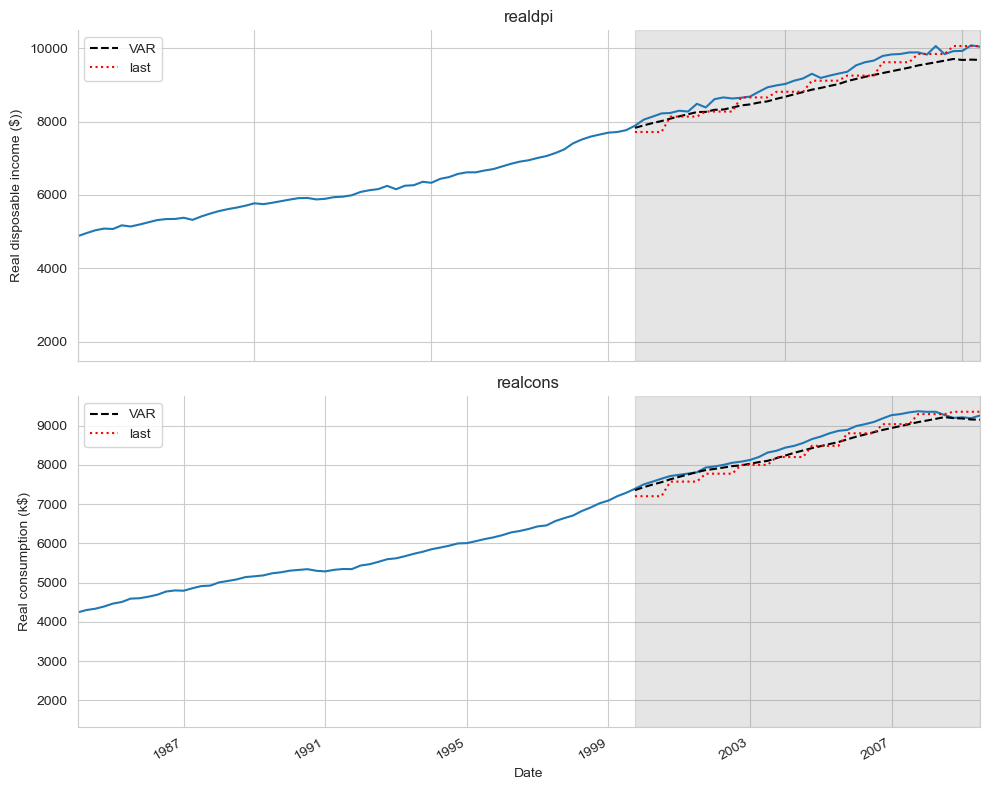

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

## Calculating the error

In [39]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

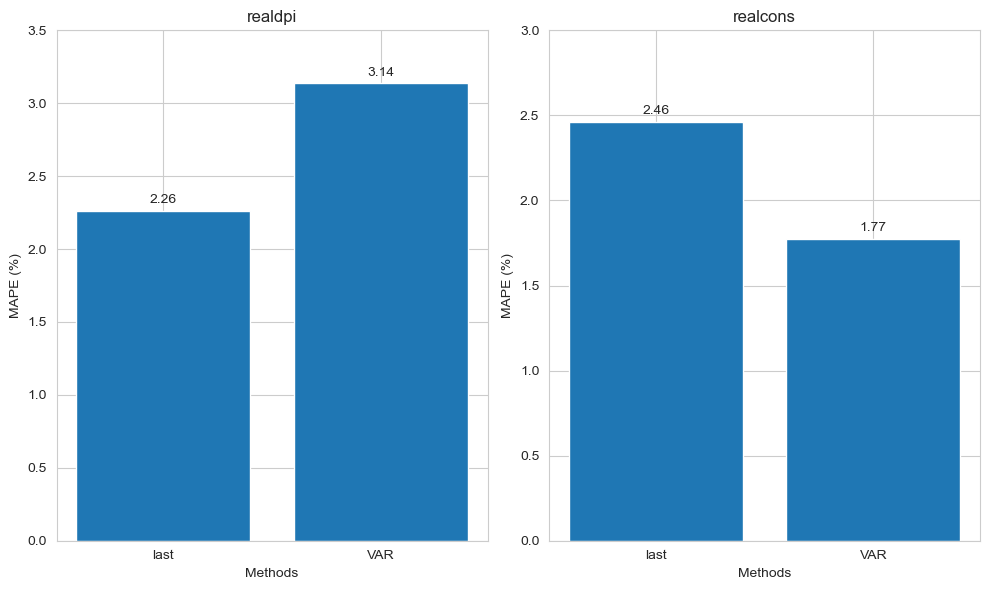

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()



* As we can see the model performs worse than baseline for 'realcons' but better for 'realcons'.
* So, we can conclude that 'realcons' and 'realdpi' are not predeictive enough to make accurate forcasts.
* So, using a SARIMAX model would have been better for this case.